In [1]:
import numpy as np
import os
from pathlib import Path
import pandas as pd
from tqdm import tqdm
import sys
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch import Tensor, Size
from torch.distributions import Distribution

os.environ['pRT_input_data_path'] = os.path.join('/home/mvasist/pRT/input_data_v2.4.9/input_data')
import petitRADTRANS as prt
from petitRADTRANS.retrieval.util import *
import petitRADTRANS.retrieval.parameter as prm
from petitRADTRANS.retrieval.data import Data
from petitRADTRANS import nat_cst as nc, Radtrans
from petitRADTRANS.retrieval import cloud_cond as fc
from petitRADTRANS.retrieval.util import calc_MMW, compute_gravity, spectrum_cgs_to_si, surf_to_meas

from lampe.distributions import BoxUniform

sys.path.insert(0, '/home/mvasist/WISEJ1738/sbi') #WISEJ1738/sbi
from emission_model_clouds import emission_model_diseq, temp_model_nodes, get_abundances


from added_scripts.pt_plotting import *

from ees_MIRIinst import Simulator as Simulator_cloudfree
from eesclouds_MIRIinst import Simulator as Simulator_cloudy
from eesclouds_MIRIinsts import Simulator as Simulator_cloudys
from ees_MIRIinsts import Simulator as Simulator_cloudfrees


# simulator_miri_cloudy = Simulator_cloudy(4.9, 19.0, noisy=False)
# simulator_hst_cloudy = Simulator_cloudy(0.98, 2.2, noisy=False)

# simulator_miri_cloudfree = Simulator_cloudfree(4.9, 19.0, noisy=False)
# simulator_hst_cloudfree = Simulator_cloudfree(0.98, 2.2, noisy=False)

from code2explore.NPE_new import NPEWithEmbedding_sepEmb
from code2explore.observations import load_observations
from code2explore.parameters import theta2parameters
from code2explore.flexible_simulator import pt_profile_theta, pt_profile_parameters, pressureCGS, \
                                            pressureBAR, simulator



ModuleNotFoundError: No module named 'emission_model_clouds'

In [ ]:
# observations
obs_wlen_miri, obs_miri, sigmaM, \
            obs_wlen_gemini, obs_gemini, sigmaG, \
            obs_wlen_hst, obs_hst, sigmaH, \
            wlength_gm, wlength_hm, \
            x_star_g, x_star_h = load_observations()


In [ ]:
obs_wlen_inst = np.append(obs_wlen_hst, obs_wlen_gemini)
index_argsort = np.argsort(obs_wlen_inst)

obs_inst_app = np.append(obs_hst, obs_gemini)
obs_inst = obs_inst_app[index_argsort]
x_star_hg = np.append(obs_inst, obs_miri)


In [ ]:
os.environ['SCRATCH'] = os.path.join('/scratch/users/mvasist')
scratch = os.environ.get('SCRATCH')

In [6]:
th_den = torch.tensor([[ 1.4422e+00,  1.1456e+01,  3.6611e+03,  4.1704e-01,  6.7397e-01,
          4.8530e-01,  6.4675e-01,  5.9171e-01,  9.3285e-01,  2.2592e-01,
          8.7773e-01,  3.9113e-01, -1.7942e+00, -5.9351e+00, -3.6824e+00,
         -1.7959e+00, -3.4017e+00, -8.5875e+00, -2.8700e+00, -6.2074e+00,
         -8.1657e+00, -6.2734e+00, -9.4773e+00, -1.6240e+00, -2.7775e+00,
          1.1013e+01,  6.7556e+00,  2.0624e+00, -1.6553e+01, -1.2515e+01,
         -9.2240e+00] ])

In [22]:
D = 7.34
Rcf = 1.14 
Rcl = 1.39
Rmix = 1.20
Rpat = 1.4

## MIRI_old

In [23]:
spec = pd.read_csv('MIRI/unconvolved/spectrum.csv', header=0, delimiter = ',')
spec

,wavelength[um],flux[Jy],error[Jy]
0,4.909755,0.000256,0.000025
1,4.914667,0.000382,0.000024
2,4.919584,0.000307,0.000025
3,4.924506,0.000470,0.000028
4,4.929433,0.000314,0.000024
...,...,...,...
1293,17.889679,0.000289,0.000054
1294,17.907578,0.000216,0.000055
1295,17.925494,0.000085,0.000054
1296,17.943429,0.000120,0.000053


In [7]:
fl = spec.iloc[:,1].values * nc.c  /(1e7 * 1e23 * (spec.iloc[:,0].values*1e-4)**2.) 

In [8]:
Teff = teff_calc(spec.iloc[:,0].values, fl, dist=7.34, r_pl= 2.3168979e-9* 0.8)

In [9]:
Teff

387.1399346237512

## MIRI reprocessed

In [10]:
fl = obs_miri*1e-5 * nc.c  /(1e7 * 1e23 * (obs_wlen_miri*1e-4)**2.)  

Teff = teff_calc( obs_wlen_miri, fl , dist=7.34, r_pl= 2.3168979e-9* R)
Teff

NameError: name 'R' is not defined

## HST

In [ ]:
fl = obs_hst*1e-5 * nc.c  /(1e7 * 1e23 * (obs_wlen_hst*1e-4)**2.)  

Teff = teff_calc( obs_wlen_hst, fl/(D/9.9)**2 , dist=7.34, r_pl= 2.3168979e-9* R)
Teff

## Gemini

In [ ]:
fl = obs_gemini*1e-5 * nc.c  /(1e7 * 1e23 * (obs_wlen_gemini*1e-4)**2.)  

Teff = teff_calc( obs_wlen_gemini, fl/(D/9.9)**2 , dist=7.34, r_pl= 2.3168979e-9* R)
Teff

## MIRI + Gemini

In [ ]:
fl = x_star_g*1e-5 * nc.c  /(1e7 * 1e23 * (wlength_gm*1e-4)**2.)  

Teff = teff_calc( wlength_gm, fl/(D/9.9)**2 , dist=7.34, r_pl= 2.3168979e-9* R)
Teff

## MIRI + HST

In [ ]:
fl = x_star_h*1e-5 * nc.c  /(1e7 * 1e23 * (wlength_hm*1e-4)**2.)  

Teff = teff_calc( wlength_hm, fl/(D/9.9)**2 , dist=7.34, r_pl= 2.3168979e-9* R)
Teff

## Using simulations

In [39]:

# th = torch.Tensor([ 1.4437e+00,  1.5085e+01,  3.2942e+03,  4.8148e-01,  5.7518e-01,
#           5.4268e-01,  6.5721e-01,  4.9237e-01,  9.9410e-01,  6.8749e-01,
#           6.1358e-01,  8.5204e-01, -1.8915e+00, -6.2744e+00, -3.2647e+00,
#          -1.9112e+00, -3.4958e+00, -7.1443e+00, -4.9128e+00, -6.2636e+00,
#          -6.6149e+00, -7.7243e+00, -9.4246e+00, -3.5157e+00, -1.0331e+00,
#           5.2872e-01,  6.9916e+00,  1.8922e+00,  2.3148e-01,  1.1249e+00,
#          -9.2664e+00]) # -1.6578e+01,


In [24]:

# simulator_miri_cloudfree= Simulator_cloudfree(0.1, 250, noisy=False)
simulator_cloudfree = Simulator_cloudfrees(0.1, 250, noisy=False)

# simulator_miri_cloudy = Simulator_cloudy(0.1, 250, noisy=False)
simulator_cloudy = Simulator_cloudys(0.1, 250, noisy=False)


th = torch.Tensor([1.1069e+00,  9.1408e+00,  4.7038e+03,  3.8963e-01,  5.7228e-01,
         4.6258e-01,  6.6919e-01,  5.6300e-01,  9.7062e-01,  6.9292e-01,
         9.4360e-01,  3.5723e-01, -1.9252e+00, -5.2730e+00, -3.5699e+00,
        -1.9774e+00, -3.2523e+00, -7.2041e+00, -3.1470e+00, -6.0901e+00,
        -8.9217e+00, -8.1114e+00, -9.2704e+00,  7.1421e-01, -1.6476e+01,
        -9.2723e+00])

## filigreed-wonton-319 ep 150
th_hst = torch.Tensor([1.0862e+00,  8.2800e+00,  4.5741e+03,  2.6701e-01,  9.7918e-01,
          4.5017e-01,  6.3880e-01,  5.6958e-01,  2.6024e-01,  9.3490e-01,
          3.9886e-01,  9.1058e-01, -1.7818e+00, -5.3373e+00, -3.2079e+00,
         -1.7270e+00, -3.0317e+00, -8.6908e+00, -2.7670e+00, -6.0139e+00,
         -7.9778e+00, -7.2847e+00, -8.5109e+00,  4.9831e-01, -1.2727e+01,
         -8.9882e+00])
            
th_gem = torch.Tensor([ 1.0988e+00,  1.6071e+01,  2.1453e+03,  7.0751e-01,  6.5070e-01,
         4.6057e-01,  6.8971e-01,  4.7529e-01,  6.7283e-01,  5.8644e-01,
         3.9769e-01,  6.1192e-01, -1.8045e+00, -5.5486e+00, -3.3173e+00,
        -1.7765e+00, -3.1373e+00, -6.5028e+00, -9.1886e+00, -5.8604e+00,
        -8.6256e+00, -7.9285e+00, -9.8142e+00,  5.3877e-01, -1.5735e+01,
        -9.0864e+00])

#cf_10_ep100 bestfit 
th_hst_gem_cf = torch.Tensor([ 1.1483e+00,  1.0633e+01,  4.8318e+03,  3.5450e-01,  5.6563e-01,
          4.7644e-01,  6.8593e-01,  7.7517e-01,  7.3669e-01,  4.3708e-01,
          8.7753e-01,  5.6221e-01, -2.0836e+00, -5.8071e+00, -3.5043e+00,
         -1.9493e+00, -3.3905e+00, -9.1725e+00, -3.3423e+00, -6.5468e+00,
         -9.0502e+00, -8.4619e+00, -8.5311e+00, -1.4194e+01, -1.5726e+01,
         -9.3877e+00])

#cl_10_ep200 bestfit 
# th_hst_gem_cl = torch.Tensor([1.8245e+00,  7.3580e+00,  3.4547e+03,  4.0480e-01,  7.2984e-01,
#           5.7032e-01,  5.4696e-01,  7.3577e-01,  8.3513e-01,  3.1862e-01,
#           9.3304e-01,  9.5709e-01, -2.0333e+00, -5.8625e+00, -3.8128e+00,
#          -2.1575e+00, -3.5836e+00, -6.0792e+00, -3.3581e+00, -6.5439e+00,
#          -8.4121e+00, -6.9257e+00, -9.9490e+00, -2.0525e+00, -1.5927e+00,
#           1.7394e+00,  7.8446e+00,  2.5664e+00, -1.6574e+01, -1.5613e+01,
#          -9.2050e+00])

## optimised MAP from cl_10
th_hst_gem_cl = torch.tensor([ 2.0278e+00,  4.0692e+00,  3.3100e+03,  5.0874e-01,  6.4869e-01,
         5.8455e-01,  5.0172e-01,  6.3901e-01,  9.8911e-01,  9.1209e-01,
         6.9740e-01,  8.1115e-01, -2.1486e+00, -5.9144e+00, -3.7771e+00,
        -2.2707e+00, -3.6686e+00, -7.0822e+00, -3.5095e+00, -6.8179e+00,
        -9.0245e+00, -7.3134e+00, -9.3324e+00, -3.5159e+00, -1.1195e+00,
         5.9234e-01,  8.9260e+00,  1.7138e+00, -1.6668e+01, -1.6971e+01,
        -9.1988e+00] )

## avg post max prob 200ep all 12 archs
# th_hst_gem_cl = torch.tensor([ 1.4422e+00,  1.1456e+01,  3.6611e+03,  4.1704e-01,  6.7397e-01,
#           4.8530e-01,  6.4675e-01,  5.9171e-01,  9.3285e-01,  2.2592e-01,
#           8.7773e-01,  3.9113e-01, -1.7942e+00, -5.9351e+00, -3.6824e+00,
#          -1.7959e+00, -3.4017e+00, -8.5875e+00, -2.8700e+00, -6.2074e+00,
#          -8.1657e+00, -6.2734e+00, -9.4773e+00, -1.6240e+00, -2.7775e+00,
#           1.1013e+01,  6.7556e+00,  2.0624e+00, -1.6553e+01, -1.2515e+01,
#          -9.2240e+00 ])

#mix_10_ep200 bestfit 
th_hst_gem_mix = torch.Tensor([ 1.1927e+00,  1.5861e+01,  7.1090e+03,  2.5732e-01,  4.5543e-01,
          5.0323e-01,  6.8146e-01,  6.4331e-01,  6.3390e-01,  4.4702e-01,
          8.4826e-01,  2.5001e-01, -1.9893e+00, -5.4303e+00, -3.6936e+00,
         -1.9262e+00, -3.4768e+00, -8.3873e+00, -6.3617e+00, -5.9898e+00,
         -8.5084e+00, -9.7171e+00, -9.2953e+00, -9.9997e+00, -6.0008e+00,
          1.4994e+01,  1.2997e+01,  3.0001e+00,  9.9982e-02, -1.6371e+01,
         -1.6323e+01, -1.1111e+01])

#pat_10_ep100 bestfit 
th_hst_gem_pat = torch.Tensor([  1.1880e+00,  9.7811e+00,  3.9592e+03,  4.3600e-01,  5.5492e-01,
          5.0215e-01,  5.8263e-01,  8.5174e-01,  3.4527e-01,  7.6511e-01,
          7.5254e-01,  9.8788e-01, -2.0698e+00, -5.5657e+00, -3.5048e+00,
         -2.0430e+00, -3.5012e+00, -9.7038e+00, -3.4180e+00, -6.3582e+00,
         -9.0674e+00, -6.8465e+00, -8.5383e+00, -4.3836e+00, -2.7274e+00,
          3.4917e+00,  5.1509e+00,  2.4515e+00,  1.8918e-01, -1.2699e+01,
         -1.2346e+01, -9.0121e+00])

In [25]:
th.size()

torch.Size([26])

In [26]:
# x = simulator_miri_cloudfree(th.numpy())
# x_hst = simulator_miri_cloudfree(th_hst.numpy())
# x_gem = simulator_miri_cloudfree(th_gem.numpy())
x_hst_gem_cf = simulator_cloudfree(th_hst_gem_cf.numpy())
x_hst_gem_cl = simulator_cloudy(th_hst_gem_cl.numpy())
x_hst_gem_mix = simulator_cloudy(np.delete(th_hst_gem_mix.numpy(), -4))
h = th_hst_gem_cf[-4]
x_hst_gem_pat = (1-h) * simulator_cloudy(np.delete(th_hst_gem_pat.numpy(), -4)) + \
                h * simulator_cloudfree(np.delete(th_hst_gem_pat.numpy(), [23,24,25,26,27,28,29]))


<class 'numpy.ndarray'> <class 'float'> [7.18326516e-11 7.39758713e-11 7.61805696e-11 ... 8.99207616e-06
 8.89488796e-06 9.82310533e-06]
<class 'numpy.ndarray'> <class 'float'> [1.07714103e-13 1.11658786e-13 1.15743424e-13 ... 9.16294091e-06
 8.75261535e-06 1.04873466e-05]


In [27]:
# s = simulator_miri_cloudfree.wavelength[simulator_miri_cloudfree.wavelength>1]
s_ = simulator_cloudfree.wavelength[simulator_cloudfree.wavelength>1]

# p =  simulator_miri_cloudfree.wavelength[simulator_miri_cloudfree.wavelength>0.8]
p_ =  simulator_cloudfree.wavelength[simulator_cloudfree.wavelength>0.8]


In [28]:
simulator_cloudfree.wavelength>0.8

array([False, False, False, ...,  True,  True,  True])

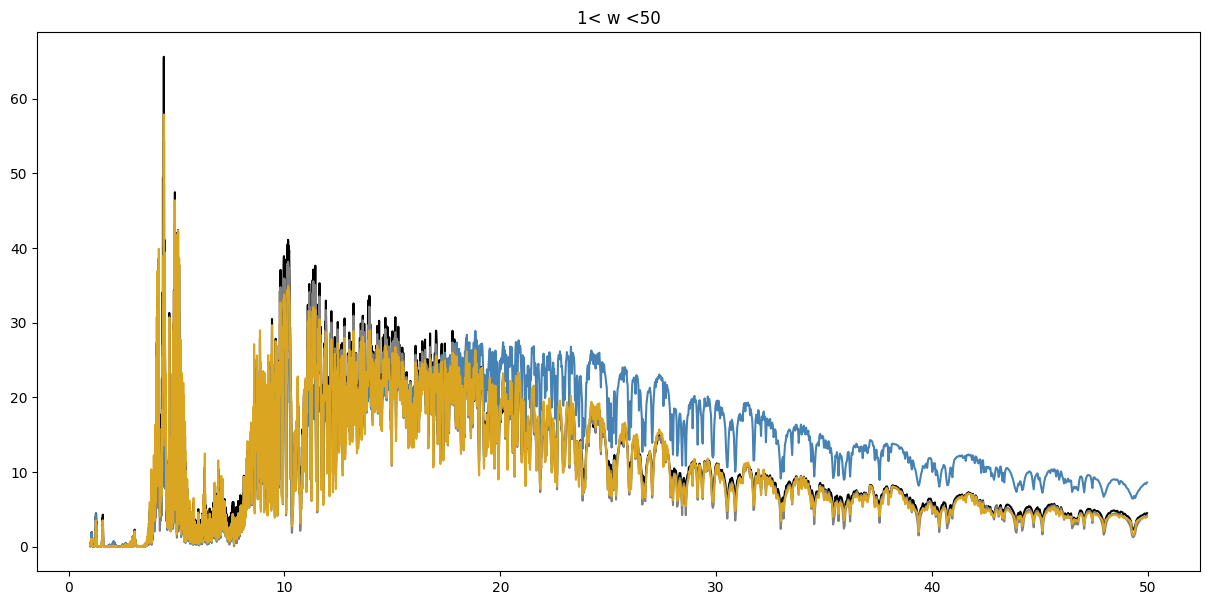

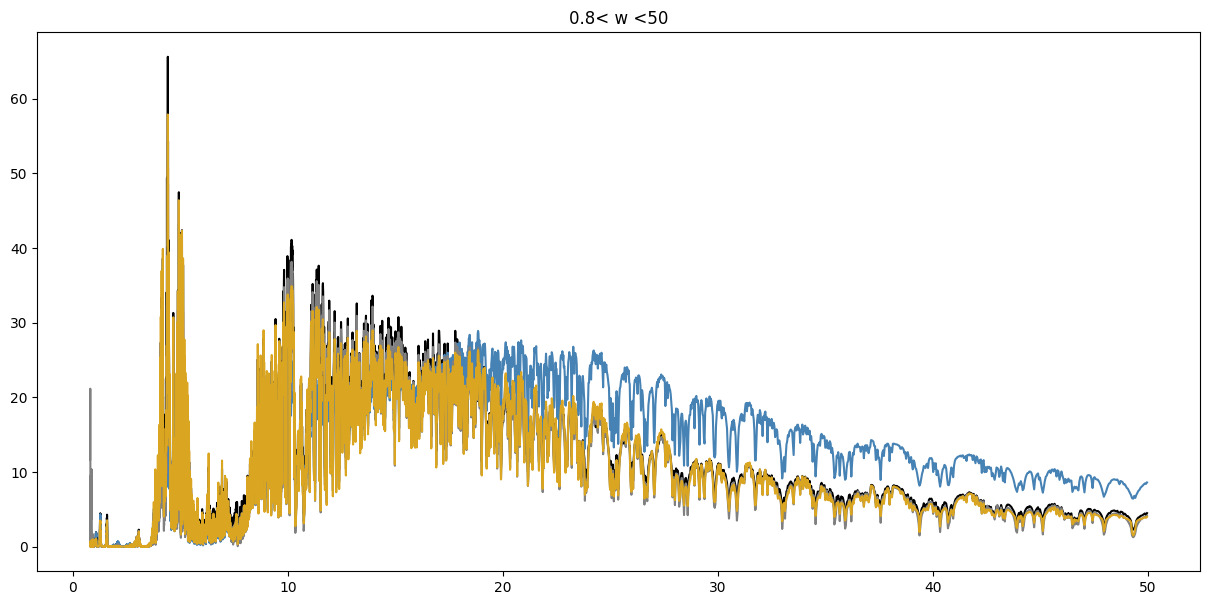

In [29]:

plt.figure(figsize= (15,7))
plt.title('1< w <50')
# plt.plot(simulator_miri_cloudfree.wavelength, x)
# plt.plot(s[s<50], x[simulator_miri_cloudfree.wavelength>1][s<50], color = 'black')
# plt.plot(s[s<50], x_hst[simulator_miri_cloudfree.wavelength>1][s<50], color='steelblue')
# plt.plot(s[s<50], x_gem[simulator_miri_cloudfree.wavelength>1][s<50], color = 'goldenrod')

plt.plot(s_[s_<50], x_hst_gem_cf[simulator_cloudfree.wavelength>1][s_<50], color = 'black')
plt.plot(s_[s_<50], x_hst_gem_cl[simulator_cloudfree.wavelength>1][s_<50], color = 'steelblue')
plt.plot(s_[s_<50], x_hst_gem_mix[simulator_cloudfree.wavelength>1][s_<50], color = 'grey')
plt.plot(s_[s_<50], x_hst_gem_pat[simulator_cloudfree.wavelength>1][s_<50], color = 'goldenrod')
# plt.plot(s_[s_<50], x_star_hg[simulator_cloudfree.wavelength>1][s_<50], color = 'red')


plt.show()

plt.figure(figsize= (15,7))
plt.title('0.8< w <50')
# plt.plot(p[p<50], x[simulator_miri_cloudfree.wavelength>0.8][p<50], color='black')
# plt.plot(p[p<50], x_hst[simulator_miri_cloudfree.wavelength>0.8][p<50], color= 'steelblue')
# plt.plot(p[p<50], x_gem[simulator_miri_cloudfree.wavelength>0.8][p<50], color = 'goldenrod')

plt.plot(p_[p_<50], x_hst_gem_cf[simulator_cloudfree.wavelength>0.8][p_<50], color = 'black')
plt.plot(p_[p_<50], x_hst_gem_cl[simulator_cloudfree.wavelength>0.8][p_<50], color = 'steelblue')
plt.plot(p_[p_<50], x_hst_gem_mix[simulator_cloudfree.wavelength>0.8][p_<50], color = 'grey')
plt.plot(p_[p_<50], x_hst_gem_pat[simulator_cloudfree.wavelength>0.8][p_<50], color = 'goldenrod')
# plt.plot(p_[p_<50], x_star_hg[simulator_cloudfree.wavelength>0.8][p_<50], color = 'red')




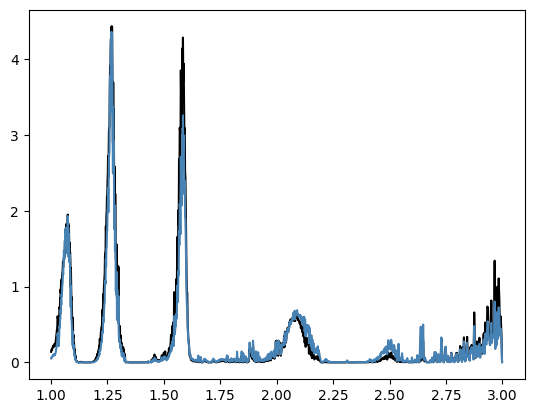

In [30]:
plt.plot(s_[s_<3], x_hst_gem_cf[simulator_cloudfree.wavelength>1][s_<3], color = 'black')
plt.plot(s_[s_<3], x_hst_gem_cl[simulator_cloudfree.wavelength>1][s_<3], color = 'steelblue')
# plt.plot(s_[s_<2], x_hst_gem_mix[simulator_cloudfree.wavelength>1][s_<2], color = 'grey')
# plt.plot(s_[s_<2], x_hst_gem_pat[simulator_cloudfree.wavelength>1][s_<2], color = 'goldenrod')


In [31]:
x_hst_gem_mix

array([0.17860691, 0.18209835, 0.18565389, ..., 0.84621722, 0.84454612,
       0.94028167])

In [32]:
## 0.1 < w < 250
# fl = x*1e-5 * nc.c  /(1e7 * 1e23 * (simulator_miri_cloudfree.wavelength*1e-4)**2.)  
# fl_hst = x_hst*1e-5 * nc.c  /(1e7 * 1e23 * (simulator_miri_cloudfree.wavelength*1e-4)**2.)  
# fl_gem = x_gem*1e-5 * nc.c  /(1e7 * 1e23 * (simulator_miri_cloudfree.wavelength*1e-4)**2.)  
fl_hst_gem_cf = x_hst_gem_cf*1e-5 * nc.c  /(1e7 * 1e23 * (simulator_cloudfree.wavelength*1e-4)**2.)  
fl_hst_gem_cl = x_hst_gem_cl*1e-5 * nc.c  /(1e7 * 1e23 * (simulator_cloudfree.wavelength*1e-4)**2.)  
fl_hst_gem_mix = x_hst_gem_mix*1e-5 * nc.c  /(1e7 * 1e23 * (simulator_cloudfree.wavelength*1e-4)**2.)  
fl_hst_gem_pat = x_hst_gem_pat*1e-5 * nc.c  /(1e7 * 1e23 * (simulator_cloudfree.wavelength*1e-4)**2.)  


# Teff = teff_calc( simulator_miri_cloudfree.wavelength, fl/(D/9.9)**2 , dist=7.34, r_pl= 2.3168979e-9* R)
# Teff_hst = teff_calc( simulator_miri_cloudfree.wavelength, fl_hst/(D/9.9)**2 , dist=7.34, r_pl= 2.3168979e-9* R)
# Teff_gem = teff_calc( simulator_miri_cloudfree.wavelength, fl_gem/(D/9.9)**2 , dist=7.34, r_pl= 2.3168979e-9* R)
Teff_hst_gem_cf = teff_calc( simulator_cloudfree.wavelength, fl_hst_gem_cf/(D/9.9)**2 , dist=7.34, r_pl= 2.3168979e-9* Rcf)
Teff_hst_gem_cl = teff_calc( simulator_cloudfree.wavelength, fl_hst_gem_cl/(D/9.9)**2 , dist=7.34, r_pl= 2.3168979e-9* Rcl)
Teff_hst_gem_mix = teff_calc( simulator_cloudfree.wavelength, fl_hst_gem_mix/(D/9.9)**2 , dist=7.34, r_pl= 2.3168979e-9* Rmix)
Teff_hst_gem_pat = teff_calc( simulator_cloudfree.wavelength, fl_hst_gem_pat/(D/9.9)**2 , dist=7.34, r_pl= 2.3168979e-9* Rpat)

# Teff, Teff_hst, Teff_gem, 
Teff_hst_gem_cf, Teff_hst_gem_cl, Teff_hst_gem_mix, Teff_hst_gem_pat


(1850.1493918913775, 718.8625704670994, 4435.299826494816, 950.7920844618592)

In [33]:
# np.shape(s_), np.shape(fll_hst_gem_cf)

In [34]:
## 1 < w < 250

# fll = x[simulator_miri_cloudfree.wavelength>1]*1e-5 * nc.c  /(1e7 * 1e23 * (s*1e-4)**2.)  
# fll_hst = x_hst[simulator_miri_cloudfree.wavelength>1]*1e-5 * nc.c  /(1e7 * 1e23 * (s*1e-4)**2.)  
# fll_gem = x_gem[simulator_miri_cloudfree.wavelength>1]*1e-5 * nc.c  /(1e7 * 1e23 * (s*1e-4)**2.)  
fll_hst_gem_cf = x_hst_gem_cf[simulator_cloudfree.wavelength>1]*1e-5 * nc.c  /(1e7 * 1e23 * (s_*1e-4)**2.)  
fll_hst_gem_cl = x_hst_gem_cl[simulator_cloudfree.wavelength>1]*1e-5 * nc.c  /(1e7 * 1e23 * (s_*1e-4)**2.) 
fll_hst_gem_mix = x_hst_gem_mix[simulator_cloudfree.wavelength>1]*1e-5 * nc.c  /(1e7 * 1e23 * (s_*1e-4)**2.)  
fll_hst_gem_pat = x_hst_gem_pat[simulator_cloudfree.wavelength>1]*1e-5 * nc.c  /(1e7 * 1e23 * (s_*1e-4)**2.)  


# Tefff = teff_calc( s, fll/(D/9.9)**2 , dist=7.34, r_pl= 2.3168979e-9* R)
# Tefff_hst = teff_calc( s, fll_hst/(D/9.9)**2 , dist=7.34, r_pl= 2.3168979e-9* R)
# Tefff_gem = teff_calc( s, fll_gem/(D/9.9)**2 , dist=7.34, r_pl= 2.3168979e-9* R)
Tefff_hst_gem_cf = teff_calc( s_, fll_hst_gem_cf/(D/9.9)**2 , dist=7.34, r_pl= 2.3168979e-9* Rcf)
Tefff_hst_gem_cl = teff_calc( s_, fll_hst_gem_cl/(D/9.9)**2 , dist=7.34, r_pl= 2.3168979e-9* Rcl)
Tefff_hst_gem_mix = teff_calc( s_, fll_hst_gem_mix/(D/9.9)**2 , dist=7.34, r_pl= 2.3168979e-9* Rmix)
Tefff_hst_gem_pat = teff_calc( s_, fll_hst_gem_pat/(D/9.9)**2 , dist=7.34, r_pl= 2.3168979e-9* Rpat)


# Teff, Tefff_hst, Tefff_gem,
Tefff_hst_gem_cf, Tefff_hst_gem_cl, Tefff_hst_gem_mix, Tefff_hst_gem_pat

(400.6655572986222, 350.2537820901592, 376.1858520993543, 357.34917874169065)

In [35]:
## 0.8 < w < 50


# flll = x[simulator_miri_cloudfree.wavelength>0.8][p<50]*1e-5 * nc.c  /(1e7 * 1e23 * (p[p<50]*1e-4)**2.)  
# flll_hst = x_hst[simulator_miri_cloudfree.wavelength>0.8][p<50]*1e-5 * nc.c  /(1e7 * 1e23 * (p[p<50]*1e-4)**2.)  
# flll_gem = x_gem[simulator_miri_cloudfree.wavelength>0.8][p<50]*1e-5 * nc.c  /(1e7 * 1e23 * (p[p<50]*1e-4)**2.)  
flll_hst_gem_cf = x_hst_gem_cf[simulator_cloudfree.wavelength>0.8][p_<50]*1e-5 * nc.c  /(1e7 * 1e23 * (p_[p_<50]*1e-4)**2.)  
flll_hst_gem_cl = x_hst_gem_cl[simulator_cloudfree.wavelength>0.8][p_<50]*1e-5 * nc.c  /(1e7 * 1e23 * (p_[p_<50]*1e-4)**2.)  
flll_hst_gem_mix = x_hst_gem_mix[simulator_cloudfree.wavelength>0.8][p_<50]*1e-5 * nc.c  /(1e7 * 1e23 * (p_[p_<50]*1e-4)**2.)  
flll_hst_gem_pat = x_hst_gem_pat[simulator_cloudfree.wavelength>0.8][p_<50]*1e-5 * nc.c  /(1e7 * 1e23 * (p_[p_<50]*1e-4)**2.)  


# Teffff = teff_calc( p[p<50], flll/(D/9.9)**2 , dist=7.34, r_pl= 2.3168979e-9* R)
# Teffff_hst = teff_calc( p[p<50], flll_hst/(D/9.9)**2 , dist=7.34, r_pl= 2.3168979e-9* R)
# Teffff_gem = teff_calc( p[p<50], flll_gem/(D/9.9)**2 , dist=7.34, r_pl= 2.3168979e-9* R)
Teffff_hst_gem_cf = teff_calc( p_[p_<50], flll_hst_gem_cf/(D/9.9)**2 , dist=7.34, r_pl= 2.3168979e-9* Rcf)
Teffff_hst_gem_cl = teff_calc( p_[p_<50], flll_hst_gem_cl/(D/9.9)**2 , dist=7.34, r_pl= 2.3168979e-9* Rcl)
Teffff_hst_gem_mix = teff_calc( p_[p_<50], flll_hst_gem_mix/(D/9.9)**2 , dist=7.34, r_pl= 2.3168979e-9* Rmix)
Teffff_hst_gem_pat = teff_calc( p_[p_<50], flll_hst_gem_pat/(D/9.9)**2 , dist=7.34, r_pl= 2.3168979e-9* Rpat)


# Teffff, Teffff_hst, Teffff_gem, 

Teffff_hst_gem_cf, Teffff_hst_gem_cl, Tefff_hst_gem_mix, Teffff_hst_gem_pat

(401.84095444955454, 347.9730236484621, 376.1858520993543, 356.2208016407474)

In [36]:
## 0.8 < w < 250


# flll = x[simulator_miri_cloudfree.wavelength>0.8][p<50]*1e-5 * nc.c  /(1e7 * 1e23 * (p[p<50]*1e-4)**2.)  
# flll_hst = x_hst[simulator_miri_cloudfree.wavelength>0.8][p<50]*1e-5 * nc.c  /(1e7 * 1e23 * (p[p<50]*1e-4)**2.)  
# flll_gem = x_gem[simulator_miri_cloudfree.wavelength>0.8][p<50]*1e-5 * nc.c  /(1e7 * 1e23 * (p[p<50]*1e-4)**2.)  
flll_hst_gem_cf = x_hst_gem_cf[simulator_cloudfree.wavelength>0.8]*1e-5 * nc.c  /(1e7 * 1e23 * (p_*1e-4)**2.)  
flll_hst_gem_cl = x_hst_gem_cl[simulator_cloudfree.wavelength>0.8]*1e-5 * nc.c  /(1e7 * 1e23 * (p_*1e-4)**2.)  
flll_hst_gem_mix = x_hst_gem_mix[simulator_cloudfree.wavelength>0.8]*1e-5 * nc.c  /(1e7 * 1e23 * (p_*1e-4)**2.)  
flll_hst_gem_pat = x_hst_gem_pat[simulator_cloudfree.wavelength>0.8]*1e-5 * nc.c  /(1e7 * 1e23 * (p_*1e-4)**2.)  


# Teffff = teff_calc( p[p<50], flll/(D/9.9)**2 , dist=7.34, r_pl= 2.3168979e-9* R)
# Teffff_hst = teff_calc( p[p<50], flll_hst/(D/9.9)**2 , dist=7.34, r_pl= 2.3168979e-9* R)
# Teffff_gem = teff_calc( p[p<50], flll_gem/(D/9.9)**2 , dist=7.34, r_pl= 2.3168979e-9* R)
Teffff_hst_gem_cf = teff_calc( p_, flll_hst_gem_cf/(D/9.9)**2 , dist=7.34, r_pl= 2.3168979e-9* Rcf)
Teffff_hst_gem_cl = teff_calc( p_, flll_hst_gem_cl/(D/9.9)**2 , dist=7.34, r_pl= 2.3168979e-9* Rcl)
Teffff_hst_gem_mix = teff_calc( p_, flll_hst_gem_mix/(D/9.9)**2 , dist=7.34, r_pl= 2.3168979e-9* Rmix)
Teffff_hst_gem_pat = teff_calc( p_, flll_hst_gem_pat/(D/9.9)**2 , dist=7.34, r_pl= 2.3168979e-9* Rpat)


# Teffff, Teffff_hst, Teffff_gem, 

Teffff_hst_gem_cf, Teffff_hst_gem_cl, Tefff_hst_gem_mix, Teffff_hst_gem_pat

(404.39689873839717, 350.95522134501243, 376.1858520993543, 358.7079818320387)

## cloudy prior 

In [10]:
LABELS_cl, LOWER_cl, UPPER_cl = zip(*[
[                  r'$R_P$',  0.5,    3],             # R_P / R_Jupyter
# [                  r'$\log g$',   2.5,   8.5],          # log g
[                  r'$Mass$', 1,     50], 
[                  r'$T_{bottom}$',  100,   9000],      # T_bottom
[                  r'$tnode1$',  0.2,   1.0],   # temp_node_1
[                  r'$tnode2$',  0.2,   1.0],   # temp_node_2
[                  r'$tnode3$',  0.2,   1.0],   # temp_node_3
[                  r'$tnode4$',  0.2,   1.0],   # temp_node_4
[                  r'$tnode5$',  0.2,   1.0],   # temp_node_5
[                  r'$tnode6$',  0.2,   1.0],   # temp_node_6
[                  r'$tnode7$',  0.2,   1.0],   # temp_node_7
[                  r'$tnode8$',  0.2,   1.0],   # temp_node_8
[                  r'$tnode9$',  0.2,   1.0],   # temp_node_9
[                  r'$H_2O$',  -10,   0], # H2O_mol_scale \_mol\_scale
[                  r'$CO_2$',  -10,   0], # C2O_mol_scale
[                  r'$CO$',  -10,   0],  # CO_mol_scale
[                  r'$CH_4$',  -10,   0], # CH4_mol_scale
[                  r'$NH_3$',  -10,   0], # NH3_mol_scale
[                  r'$PH_3$',  -10,   0], # PH3_mol_scale
[                  r'$H_2S$',  -10,   0], # H2S_mol_scale
[                  r'$^{15}NH_3$',  -10,   0],  # 15NH3_mol_scale
[                  r'$HCN$',  -10,   0],  # SO2_mol_scale
[                  r'$TiO$',  -10,   0],  # 15NH3_mol_scale
[                  r'$VO$',  -10,   0],  # SO2_mol_scale
# [                  r'$log\_X\_cb\_H2O(c)$',  -2.3,   1],  # old
[                  r'$X_{H2Oc}$',  -10,   0],  # free cloud  [-10, 0]

# [                  r'$eq\_scaling\_H2O(c)$',  0.1,   1.6],  # C/O
[                  r'$P_{base}$',  -6,   3], # NH3_mol_scale
# [                  r'$C/O$',  0.1,   1.6],  # C/O
# [                  r'$Fe/H$', -1.5,   1.5],  # [Fe/H]
[                  r'$f_{sed}$',  0,   15], # NH3_mol_scale
[                  r'$k_{zz}$',  5,   13], # NH3_mol_scale
[                  r'$\sigma_{l}$',  1.05,   3], # NH3_mol_scale  
# [                  r'$h$',  0,      1],  # SO2_mol_scale
# [                    r'$scaling_{(g)}$',   0.5, 1.5],  # Cushing_scale_factor
[                    r'$b_{g}$', -17, -11], #Mike_Line_b_Cushing 
# [                    r'$scaling_{(w)}$',   0.5, 1.5],  # Cushing_scale_factor
[                    r'$b_{w}$', -17, -11], #Mike_Line_b_Cushing 
[                  r'$b_{m}$',  -15, -7], #Mike_Line_b_MIRI 
])

In [50]:
from lampe.distributions import BoxUniform
import torch

prior = BoxUniform(torch.tensor(LOWER_cl), torch.tensor(UPPER_cl))

th_cl = prior.sample((100,))

print(th_cl)

x_hgm_cl = torch.vstack([ torch.from_numpy(simulator_cloudy(x)) for x in tqdm(th_cl.numpy()) ])


tensor([[ 1.5684e+00,  7.5303e+00,  6.8977e+03,  ..., -1.3219e+01,
         -1.6652e+01, -1.2726e+01],
        [ 1.5844e+00,  3.9424e+01,  3.4479e+03,  ..., -1.4844e+01,
         -1.1810e+01, -1.2661e+01],
        [ 1.5331e+00,  2.8377e+01,  7.8061e+03,  ..., -1.1163e+01,
         -1.4601e+01, -1.3285e+01],
        ...,
        [ 2.8380e+00,  1.7933e+01,  6.3903e+03,  ..., -1.3705e+01,
         -1.3160e+01, -8.5067e+00],
        [ 1.2308e+00,  4.3769e+01,  6.3659e+03,  ..., -1.4187e+01,
         -1.4169e+01, -1.3737e+01],
        [ 9.5410e-01,  2.0033e+01,  9.6122e+02,  ..., -1.3956e+01,
         -1.5841e+01, -1.4398e+01]])


  0%|          | 0/100 [00:00<?, ?it/s]

Abundance sum > 1.0, msum=1.0401573712879582


 12%|█▏        | 12/100 [01:51<14:47, 10.09s/it]

Abundance sum > 1.0, msum=1.086178645494103


 14%|█▍        | 14/100 [02:01<11:06,  7.75s/it]

Abundance sum > 1.0, msum=1.1056256275166454


 16%|█▌        | 16/100 [02:11<09:21,  6.69s/it]

Abundance sum > 1.0, msum=1.2219567029151643


 32%|███▏      | 32/100 [04:42<11:30, 10.15s/it]

Abundance sum > 1.0, msum=1.134125047158321


 40%|████      | 40/100 [05:53<09:44,  9.74s/it]

Abundance sum > 1.0, msum=1.2948307247259536


 49%|████▉     | 49/100 [07:14<08:24,  9.88s/it]

Abundance sum > 1.0, msum=1.0128162473023992


 54%|█████▍    | 54/100 [07:54<06:53,  8.99s/it]

Abundance sum > 1.0, msum=1.2091779175450232
Abundance sum > 1.0, msum=1.1561288058096622


 85%|████████▌ | 85/100 [12:47<02:34, 10.29s/it]

Abundance sum > 1.0, msum=1.21540490499012


 89%|████████▉ | 89/100 [13:16<01:36,  8.81s/it]

Abundance sum > 1.0, msum=1.2399265418315086
Abundance sum > 1.0, msum=1.1796661327546158


100%|██████████| 100/100 [14:47<00:00,  8.87s/it]


In [51]:
x_hgm_cl.size()

torch.Size([100, 7824])

In [56]:
# save_tchvalues_to_files(savepath_plots_hg/'x_fromPrior.csv', x_hgm_cl)

saved


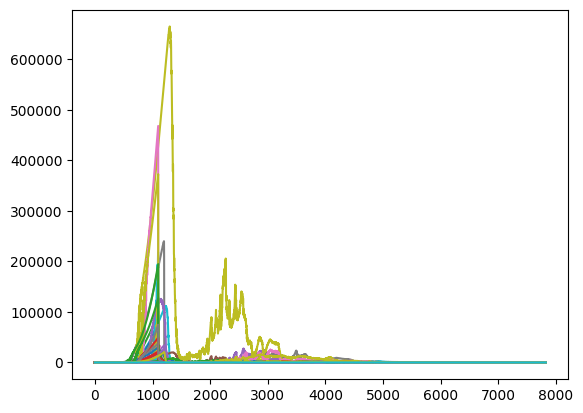

In [52]:
for i in range(100):
    plt.plot(x_hgm_cl[i])

In [61]:
D=7.34
fl_hg_cl = x_hgm_cl*1e-5 * nc.c  /(1e7 * 1e23 * (simulator_cloudfree.wavelength*1e-4)**2.)  
print(fl_hg_cl)

Teff_hg_cl = []
for i in range(100):
    Teff_hg_cl.append( teff_calc( simulator_cloudfree.wavelength, fl_hg_cl[i]/(D/9.9)**2 , dist=7.34, r_pl= th_cl[i,0]* 2.3168979e-9) )



tensor([[       nan,        nan,        nan,  ...,        nan,        nan,
                nan],
        [2.0628e-24, 2.1407e-24, 2.2215e-24,  ..., 1.2294e-22, 1.2371e-22,
         2.6660e-21],
        [6.3451e-23, 6.5524e-23, 6.7663e-23,  ..., 3.2179e-21, 3.2168e-21,
         3.2499e-21],
        ...,
        [5.7393e-16, 5.8476e-16, 5.9577e-16,  ..., 2.0146e-21, 2.0506e-21,
         8.2712e-21],
        [1.2895e-16, 1.3140e-16, 1.3390e-16,  ..., 8.3112e-22, 7.8243e-22,
         1.7755e-21],
        [3.5673e-73, 4.1384e-73, 4.8001e-73,  ..., 6.7315e-23, 5.4307e-23,
         2.4488e-22]], dtype=torch.float64)


In [62]:
Teff_hg_cl

[nan,
 411.57067366492737,
 4151.7310101816865,
 909.9964311166837,
 698.1230450056755,
 22.989714546967768,
 60.61678400044301,
 4992.82574959113,
 1309.0958705687378,
 4405.172016949198,
 3025.8395124930685,
 338.2619475517777,
 nan,
 540.278519853411,
 nan,
 518.0724025440398,
 nan,
 2298.0428038259756,
 1095.1721408405087,
 2460.2132895576633,
 46.00870017335467,
 1580.8297877088003,
 955.9736122297986,
 654.9062817718419,
 3293.4116166208437,
 119.75110780193805,
 290.15373655714274,
 1155.870875017336,
 1399.6521640926092,
 140.13158119449082,
 492.36399390223306,
 861.4474706867832,
 nan,
 2248.5206977581806,
 2966.817759126041,
 5232.80105181143,
 1081.250895697909,
 4835.46166741931,
 2345.633925536079,
 804.9350991041392,
 nan,
 991.8409953208569,
 80.48316484210818,
 631.6264421107941,
 3147.0495633325,
 467.22113673853494,
 1960.3556719852538,
 1570.696991919896,
 6163.103290425002,
 nan,
 485.51752542039833,
 1007.6758115661507,
 119.60867807304568,
 235.33482546779967,
 n

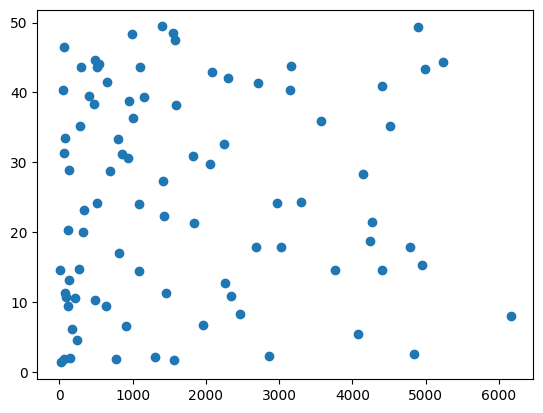

In [76]:
plt.scatter(Teff_hg_cl, th_cl[:,1])
plt.show()

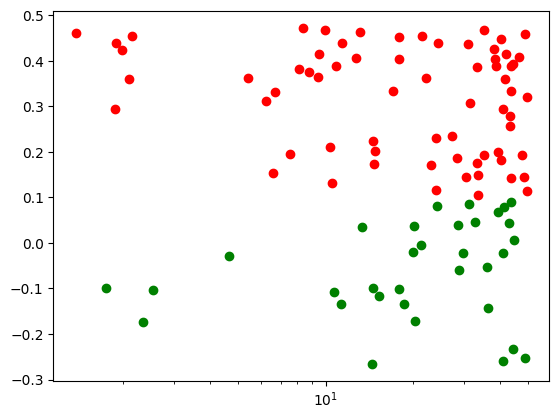

In [77]:
mask = np.log10(th_cl[:,0])> 0.1

                
plt.scatter(th_cl[mask,1], np.log10(th_cl[mask,0]), color= 'red')
plt.scatter(th_cl[~mask,1], np.log10(th_cl[~mask,0]), color= 'green')

plt.xscale('log')

In [23]:
def return_tchvalues_from_files(path):
    df_v = pd.read_csv(path)
    v = df_v.values
    v = torch.from_numpy(v)
    
    return v

def save_tchvalues_to_files(path, v):
    df_v = pd.DataFrame(v) #convert to a dataframe
    df_v.to_csv(path,index=False) #save to file
    
    return print('saved')

datapath_hg = Path(scratch) / 'JWST/runs/WISEJ1738/model_15NH3HCNTiOVOXH2OcLPbasefsedkzzslnbfacM_unregPT/MIRI+HST+Gemini/cloudy' #/sweep'

runpath_hg = datapath_hg /  'cl_10' #'curious-cherry-299' 
ep_hg = 200
savepath_plots_hg = runpath_hg  / ('plots_' + str(ep_hg) + '_reprocessed231123' )
thetamhg_ = return_tchvalues_from_files(savepath_plots_hg/'theta_512_MIRI.csv')
xmhg_ = return_tchvalues_from_files(savepath_plots_hg / 'x_512_MIRI.csv')
thetahgg_ = return_tchvalues_from_files(savepath_plots_hg/'theta_512_Gemini.csv')
xhgg_ = return_tchvalues_from_files(savepath_plots_hg / 'x_512_Gemini.csv')
thetahhg_ = return_tchvalues_from_files(savepath_plots_hg/'theta_512_HST.csv')
xhhg_ = return_tchvalues_from_files(savepath_plots_hg / 'x_512_HST.csv')

rankshg = return_tchvalues_from_files(savepath_plots_hg / 'ranks.csv')

thetahgm = return_tchvalues_from_files(savepath_plots_hg/'theta.csv')


In [24]:
xh = np.append(xhhg_, xhgg_, axis = -1)
xhi = xh[:,index_argsort]
x_star_hg = np.append(xhi, xmhg_, axis = -1)

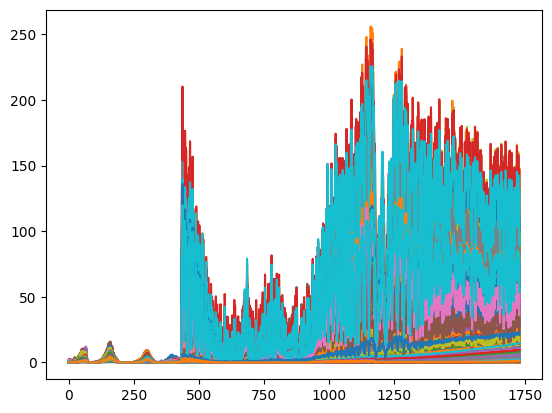

In [57]:
for i in range(len(x_star_hg)):
    plt.plot(x_star_hg[i])


In [ ]:
'''
Im trying to understand whether the radius has to be resclaed or not after the retrieval. 
the retreival finds the best theta whoch explians the spectrum which is an obejcet projected 
to be at a distance of 9.9pc. so now do i rescale the radius. becuase the radius is also of an object 
seen at a distance of 9.9.

yes, because the object and the data are scaled to a distance of 9.9. so the best fit is going to match the 
exact same object at the distance 9.9pc. say we bring it to 7.34, the radius must be (7.34/9.9)**2
'''
